In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [141]:
from src import config
from src.util import video2images, get_video_folder_paths
from src.model import autolabel_images
from src.dataset_processing import run_processing_dataset
import os
import json
import supervision as sv
import cv2

In [56]:
# convertir los video en imagenes
# crear en el directorio raiz la ruta test\video_test\<sku del producto>
# colocar dentro un video y un archivo ontology.json con la ontología. 
video_path= get_video_folder_paths(config.VIDEO_TEST)[0]
print(video_path)

d:\Alexander\Go2Future\Autolabel_roboflow\test\video_test\7790040133488


In [57]:
# create image folder for each video folder
    
image_dir_path = os.path.join(config.IMAGE_TEST, os.path.basename(video_path))
if not os.path.exists(image_dir_path):
    os.mkdir(image_dir_path)

video2images(video_path, image_dir_path, frame_rate=200)

100%|██████████| 1/1 [00:03<00:00,  3.86s/it]


In [136]:
# create dataset folder for each video folder
if not os.path.exists(config.DATA_TEST):
    os.mkdir(config.DATA_TEST)
    
dataset_dir_path = os.path.join(config.DATA_TEST, os.path.basename(video_path))
if not os.path.exists(dataset_dir_path):
    os.mkdir(dataset_dir_path)


In [137]:

autolabel_images(
            input_folder=image_dir_path,
            ontology=json.load(open(os.path.join(video_path, "ontology.json"))),
            box_threshold=0.5,
            text_threshold=0.25,
            output_folder=dataset_dir_path,
            extension=".jpg",
        )

Labeling d:\Alexander\Go2Future\Autolabel_roboflow\test\image_test\7790040133488\7790040133488_vertical_3-00005.jpg: 100%|██████████| 6/6 [01:19<00:00, 13.25s/it]


Labeled dataset created - ready for distillation.


In [143]:
ANNOTATIONS_DIRECTORY_PATH = os.path.join(dataset_dir_path, "train","labels")
IMAGES_DIRECTORY_PATH = os.path.join(dataset_dir_path, "train", "images")
DATA_YAML_PATH = os.path.join(dataset_dir_path, "data.yaml")

# Crear una clase DetetctionDatatset para YOLO
dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

3

In [45]:
# create fuction to read a list of labels files .txt into a folder and erase empty files
# and remove images respect to the labels files

import os
def erase_empty_files(label_path, image_path):
    for lab_filename, image_filaname in zip(os.listdir(label_path), os.listdir(image_path)):
        if os.stat(os.path.join(label_path, lab_filename)).st_size == 0:
            os.remove(os.path.join(label_path, lab_filename))
            os.remove(os.path.join(image_path, image_filaname)
        )  
erase_empty_files(ANNOTATIONS_DIRECTORY_PATH ,IMAGES_DIRECTORY_PATH)    

In [142]:
run_processing_dataset(IMAGES_DIRECTORY_PATH, ANNOTATIONS_DIRECTORY_PATH, max_size=0.5, iou_threshold=0.1)


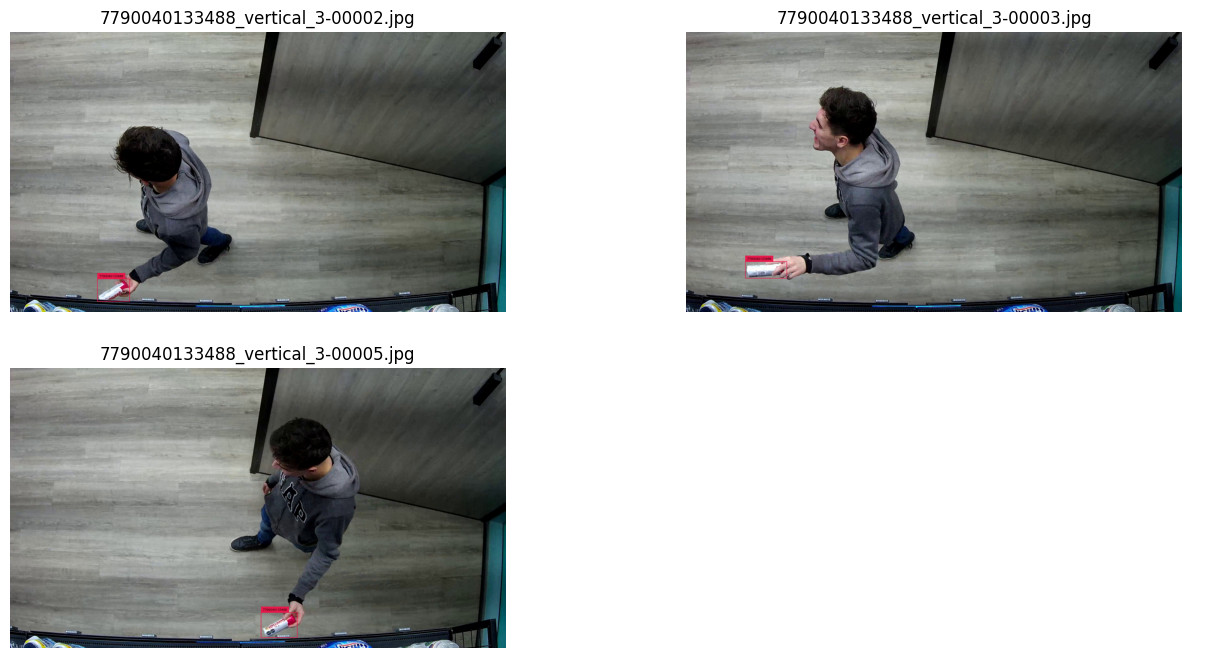

In [144]:
# Mostrar las anotaciones realizadas por el modelo base
SAMPLE_SIZE = 4
SAMPLE_GRID_SIZE = (2, 2)
SAMPLE_PLOT_SIZE = (16, 8)

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

## Llevar todas las anotaciones a un video

In [2]:
ANNOTATIONS_DIRECTORY_PATH = os.path.join(config.DATASET_DIR_PATH, "Merged_Dataset/train/labels")
IMAGES_DIRECTORY_PATH = os.path.join(config.DATASET_DIR_PATH, "Merged_Dataset/train/images")
DATA_YAML_PATH = os.path.join(config.DATASET_DIR_PATH, "Merged_Dataset/data.yaml")

# Crear una clase DetetctionDatatset para YOLO
dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

21

In [3]:
image_names = list(dataset.images.keys())

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

In [14]:
# Especificar la ruta del video de salida y la velocidad de fotogramas
video_name =os.path.join(config.DATASET_DIR_PATH, "anotaciones.mp4") 
fps = 2

# Obtener la altura y el ancho de la primera imagen
height, width, layers = images[0].shape

# Crear el objeto VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(video_name, fourcc, fps, (width,height))

# Agregar cada imagen al video
for image in images:
    video.write(image)

# Liberar el objeto VideoWriter y cerrar la ventana
cv2.destroyAllWindows()
video.release()

## Salvar imagenes anotadas para visualización

In [5]:
# Crear una carpeta para almacenar las imágenes si no existe
anotate_images=os.path.join(config.DATASET_DIR_PATH, "imagenes_anotadas")
if not os.path.exists(anotate_images):
    os.makedirs(anotate_images)


# Guardar cada imagen como un archivo individual
for idx, image in enumerate(images):
    output_path = os.path.join(anotate_images, f"imagen_{idx+1}.png")
    cv2.imwrite(output_path, image)

print("Imágenes guardadas exitosamente.")

Imágenes guardadas exitosamente.
